## Correlation

In climate data analysis we often ask questions about how two things are related to each other. 

We may have a hypothesis or physical reason why some climate phenomena may be related to or impact another part of the climate system.  We use correlation as a means to quantify this relationship. 

_Example:_

Many studies have explored the relationship between ENSO and other aspects of the climate system.  Last week, we calculated composites of precipitation based on the Nino34 index as a way of seeing how ENSO is related to changes in precipitation.  

This week we will use correlation to quantify how precipitation at each point on the globe co-varies linearly with the Nino34 index. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

### Read in the Nino34 index

In [2]:
file_nino34='/scratch/kpegion/nino34_1982-2019.oisstv2_anoms.nc'
ds_nino34=xr.open_dataset(file_nino34)
ds_nino34

<xarray.Dataset>
Dimensions:  (time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
    month    (time) int64 ...
Data variables:
    sst      (time) float32 ...

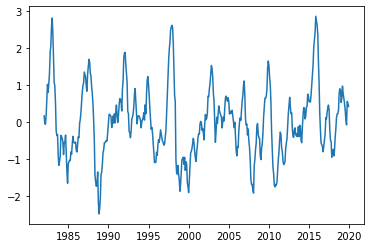

In [3]:
plt.plot(ds_nino34['time'],ds_nino34['sst'])

### Read in Precipitation Data

In [4]:
file='/shared/obs/gridded/GPCP/monthly/precip.mon.mean.nc'
ds_precip=xr.open_dataset(file)
ds_precip

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 496)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-04-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes:
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    documentation:         http://www.esrl.noaa.gov/psd/data/gridded/data.gpc...
    version:               V2.3
    Acknowledgement:       \n
    contributor_name:      Robert Adler    University of Maryland \nGeorge Hu...
    dataset_title:         Global Precipitation Climatology Project (GPCP) Mo...
    description:           https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2020/03 through latest.

### Prepare our Precipitation Data

In [5]:
# Slice time to match Nino34 data
ds_precip=ds_precip.sel(time=slice(ds_nino34['time'][0],ds_nino34['time'][-1]))

# Make anomalies
ds_climo=ds_precip.groupby('time.month').mean()
ds_anoms=ds_precip.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:   (lat: 72, lon: 144, nv: 2, time: 456)
Coordinates:
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time      (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (time, lat, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon_bnds  (time, lon, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    precip    (time, lat, lon) float32 0.011493059 0.029161826 ... -0.22516938

### Pick a point from our Precipitation Anomalies
EQ,180

In [6]:
pt=ds_anoms.sel(lat=0,lon=360-180,method='nearest')

### Plot the Nino34 index and the point together

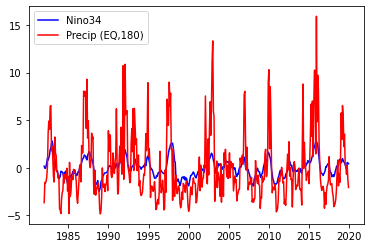

In [7]:
plt.plot(ds_nino34['time'],ds_nino34['sst'],'b')
plt.plot(pt['time'],pt['precip'],'r')
plt.legend(['Nino34','Precip (EQ,180)'])

By eye, it sort of looks like the Precipitation generally goes up when Nino34 goes up and down when Nino34 goes down.  We can quantify this using `Correlation Coefficient` or also just called `Correlation`

### Correlation Coefficient

The standard formula for calculating correlation (also sometimes called Pearson's Correlation) is:

$r_{x,y}=\frac{cov(x,y)}{\sigma_x\sigma_y}$, where

$ cov(x,y)=\sum_{i=1}^{n} (x_i-\bar{x}) (y_i-\bar{y})$

It has a range of -1 to 1.
* A value of 1 means the two timeseries are perfectly correlated
* A value of -1 means they are perfectly anti-correlated
* A value of 0 means they are uncorrelated

Typically, in climate, we perform these calculations on anomalies, so we have already removed the means $(\bar{x},\bar{y})$, so our correlation reduces to:

$r_{x,y}=\frac{\sum_{i=1}^{n} x_i y_i} {\sigma_x\sigma_y}$

In our example:

* `x` refers to Nino34
* `y` refers to our Precip anomaly point
* `n` refers to the number of times.   

### Calculate Correlation

Calculate using the `numpy` function [corrcoef](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html)

In [8]:
R=np.corrcoef(ds_nino34['sst'],pt['precip'])
R

array([[1.        , 0.69617948],
       [0.69617948, 1.        ]])

We expect a single number, but we get a matrix. 
Look at the documentation. 
This function returns a correlation coefficient `matrix`, meaning a matrix that is the correlation coefficients of:

$
R = 
\begin{bmatrix}
r_{xx} & r_{xy} \\
r_{yx} & r_{yy}
\end{bmatrix}
$

We can select the element of the correlation coefficient matrix for $r_{xy}$ or $r_{yx}$

In [9]:
corr=R[0,1]
corr

0.6961794803726128

## Correlation over a domain

Typically, we don't want just the correlation coefficient for a single point, we want it for all points over a region. 

For example, we want to make a map so we can identify where precipitation and the Nino34 index are highly correlated. 

If we have an `xarray.DataArray` we can use the `xarray.corr` function.

In [10]:
r_map=xr.corr(ds_nino34['sst'],ds_anoms['precip'],dim='time')
r_map

<xarray.DataArray (lat: 72, lon: 144)>
array([[-0.05694433, -0.06622551, -0.05550987, ..., -0.02995536,
        -0.08637335, -0.07205441],
       [-0.06641528, -0.07221564, -0.07071703, ..., -0.07246688,
        -0.1041623 , -0.08934415],
       [-0.06426396, -0.06128027, -0.05934169, ..., -0.08446326,
        -0.07028216, -0.06850251],
       ...,
       [ 0.02988956,  0.0260645 ,  0.02837396, ...,  0.01468743,
         0.01514896,  0.01578722],
       [ 0.01970439,  0.01346523,  0.01110073, ...,  0.0066614 ,
         0.01024825,  0.01364305],
       [-0.00831803, -0.0175754 , -0.02210693, ..., -0.03716743,
        -0.01487741, -0.01678541]])
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75

We get back an `xarray.DataArray` corresponding to a map of correlation coefficients. 

### Plot our correlation map

/homes/kpegion/.conda/envs/clim680/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/homes/kpegion/.conda/envs/clim680/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


Text(0.5, 1.0, 'Correlation between Nino3.4 and Precipitation Anomalies')

/homes/kpegion/.conda/envs/clim680/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


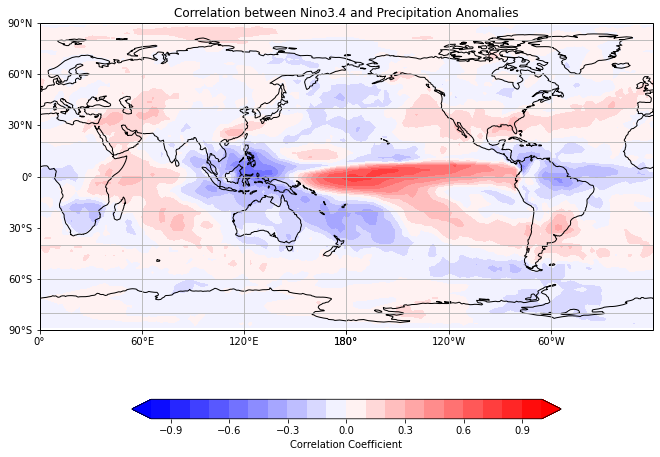

In [11]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_map
data,lon=add_cyclic_point(r_map,coord=ds_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Nino3.4 and Precipitation Anomalies')

### Interpreting our Correlation

* Red areas indicate that the precipitation goes up with Nino34 goes up and down when Nino34 goes down.
* Blue area indicate the oppposite: precipitation increases when Nino34 decreases and decreases when Nino34 increases. 
* The values near zero indicate no relationship between precipitation anomalies and Nino34. 

### How do we determine how close to zero means there is no relationship vs. a relationship?

Calculate statistical significance

## Important Reminder

You have probably heard the phrase `Correlation is NOT causation`, but what does this mean?

It means that just because two variables are highly correlated, does not mean that one variable causes the other one to vary in a certain way.  

Attributing cause comes from our understanding of the physical climate system. We have a physical understanding of how ENSO impacts the atmospheric circulation and therefore precipitation. We use correlation as a way to quantify that relationship.  

**Always be suspicious of a correlation that makes no sense!** 

## Statistical Significance of a Correlation

The purpose statistical significance is to confirm we don't make conclusions about result obtained by random chance. We want to be sure that when we find a correlation, there is in fact a relationship and we didn't just get lucky.


Let's calculate statistical significance of the correlation using the `stats` package and the function `pearsonr`.

First, let's look at the documentation for [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)

This function calculates both the correlation coefficient and the p-value indicating it the % chance that we could be wrong about it being different from zero.

#### Input

x(N,) array_like
* Nino34 index

y(N,) array_like
* Timeseries at a single point

In [16]:
from scipy.stats import pearsonr

This will not work, why not: 
r,p=pearsonr(ds_nino34['sst'],ds_anoms['precip'])

In [41]:
nx=len(ds_anoms['lon'])
ny=len(ds_anoms['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        r,p=pearsonr(ds_nino34['sst'],ds_anoms['precip'][:,j,i])
        r_array[j,i]=r
        p_array[j,i]=p
r_array.shape

(72, 144)

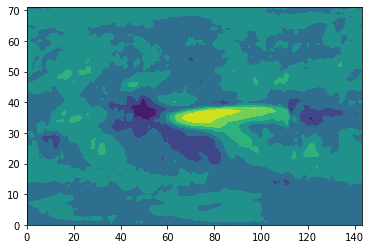

In [21]:
plt.contourf(r_array)

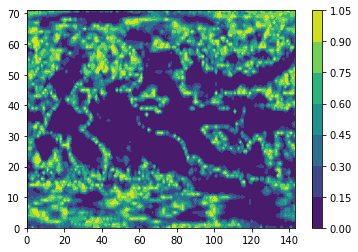

In [49]:
plt.contourf(p_array)
plt.colorbar()

### Plot our correlation including Significance

In [58]:
mask_sig=np.where(p_array<0.05,r_array,np.nan)

Text(0.5, 1.0, 'Correlation between Nino3.4 and Precipitation Anomalies')

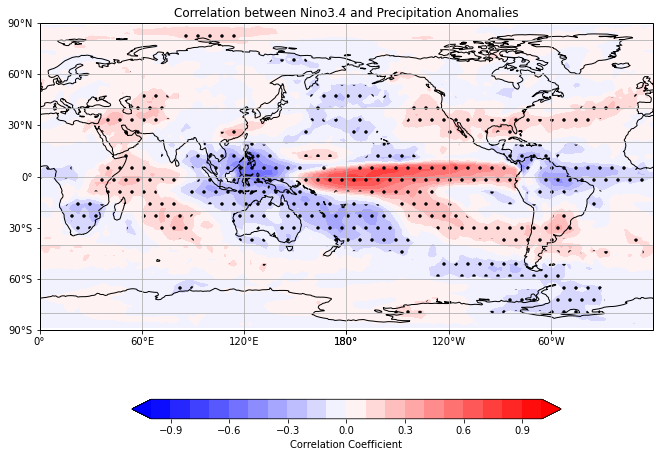

In [59]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_array
data,lon=add_cyclic_point(data,coord=ds_anoms['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=ds_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

ax.contourf(lon,ds_anoms['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Nino3.4 and Precipitation Anomalies')